### RAG Pipelines- Data Ingestion to Vector DB Pipeline

Don't forget uv add -r requirements.txt

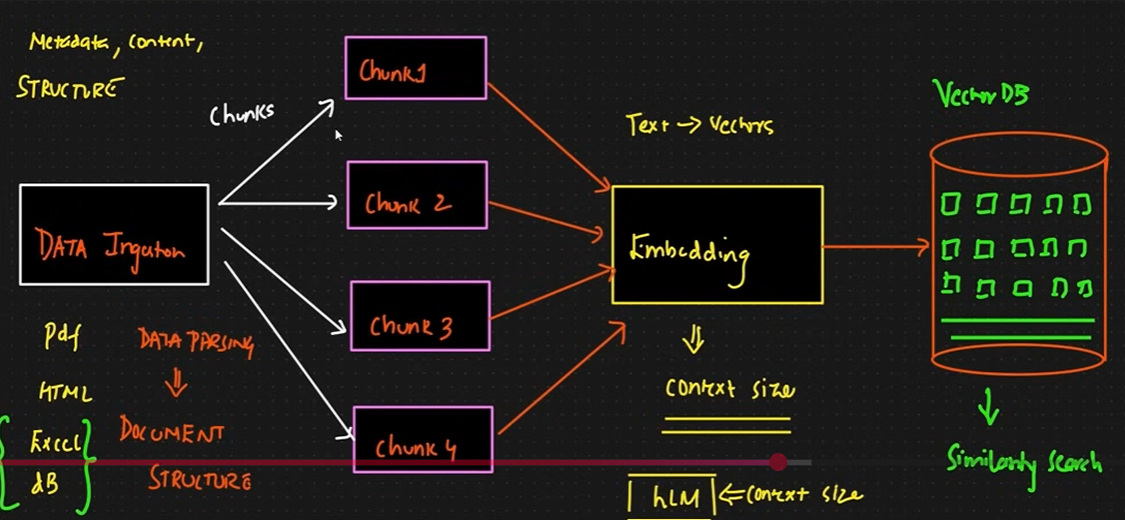

In [1]:
import os
from langchain_community.document_loaders import PyPDFLoader, PyMuPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from pathlib import Path

C:\Users\nilad\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pdf_dir = Path("../data/pdf_files")
pdfs=list(pdf_dir.glob("**/*.pdf"))
str(pdfs[0])

'..\\data\\pdf_files\\science.adw1291.pdf'

In [3]:
### Read all the pdf's inside the directory
def process_all_pdfs(pdf_directory):
    """Process all PDF files in a directory"""
    all_documents = []
    pdf_dir = Path(pdf_directory)
    
    # Find all PDF files recursively
    pdf_files = list(pdf_dir.glob("**/*.pdf"))
    
    print(f"Found {len(pdf_files)} PDF files to process")
    
    for pdf_file in pdf_files:
        print(f"\nProcessing: {pdf_file.name}")
        try:
            loader = PyPDFLoader(str(pdf_file))
            documents = loader.load()
            
            # Add source information to metadata
            for doc in documents:
                doc.metadata['source_file'] = pdf_file.name
                doc.metadata['file_type'] = 'pdf'
            
            all_documents.extend(documents)
            print(f"  ✓  Loaded {len(documents)} pages")
            
        except Exception as e:
            print(f"  ✗ Error: {e}")
    
    print(f"\nTotal documents loaded: {len(all_documents)}")
    return all_documents

# Process all PDFs in the data directory
all_pdf_documents = process_all_pdfs("../data")

Found 3 PDF files to process

Processing: science.adw1291.pdf
  ✓  Loaded 4 pages

Processing: SN_misinformation.pdf
  ✓  Loaded 15 pages

Processing: Video_models_ZS_learners_reasoners.pdf
  ✓  Loaded 46 pages

Total documents loaded: 65


In [4]:
all_pdf_documents

[Document(metadata={'producer': 'Adobe PDF Library 17.0; modified using iText 4.2.0 by 1T3XT', 'creator': 'Adobe InDesign 19.5 (Windows)', 'creationdate': '2025-10-24T19:40:28+08:00', 'moddate': '2025-11-30T15:08:48-08:00', 'trapped': '/False', 'subject': 'Science 2025.389:1012-1015', 'title': 'Improving cosmological reach of a gravitational wave observatory using Deep Loop Shaping', 'source': '..\\data\\pdf_files\\science.adw1291.pdf', 'total_pages': 4, 'page': 0, 'page_label': '1012', 'source_file': 'science.adw1291.pdf', 'file_type': 'pdf'}, page_content='Resea Rch aRticle s\nScience 4 September 2025 1012\nast ROP hYsics\nImproving cosmological reach  \nof a gravitational wave observatory \nusing Deep Loop Shaping\nJonas Buchli1*† Brendan T racey1†, T omislav Andric2,3†, \nChristopher Wipf4†, Yu Him Justin Chiu1†, Matthias Lochbrunner1†, \nCraig Donner1†, Rana X. Adhikari4*, Jan Harms2,3*†,  \nIain Barr1, Roland Hafner1, Andrea Huber1, Abbas Abdolmaleki1,  \nCharlie Beattie1, Joseph

In [5]:
all_pdf_documents[1].page_content

'ReseaR ch aR ticle s\nScience 4 September 2025 1013\nof the interferometer (i.e., the plant) is subject to dynamic variations: \nEven low absorption of the high- power laser beam (∼300 to 500 kW) \ncauses thermal distortions in the mirrors, leading to offsets in sensor \nsignals and changes in optomechanical resonant frequencies. In ad-\ndition, the high- power laser also creates substantial forces and \ntorques on the suspended mirrors, leading to optomechanical insta-\nbilities of several mechanical eigenmodes (7 –9). These resonances \nare stabilized using feedback control, but any noise injected by the \nfeedback controllers into the GW readout harms the peak astrophysi-\ncal sensitivity and drowns out the GW signals themselves.\nIn simplified terms, the main control design challenge is that \nlarger control action in lower frequencies provides better disturbance \nrejection but injects higher noise into the observation band. Con-\nversely, lowering the control action reduces inje

#### Chunking

In [6]:
### Text splitting get into chunks

def split_documents(documents,chunk_size=1000,chunk_overlap=200):
    """Split documents into smaller chunks for better RAG performance"""
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len,
        separators=["\n\n", "\n", " ", ""]
    )
    split_docs = text_splitter.split_documents(documents)
    print(f"Split {len(documents)} documents into {len(split_docs)} chunks")
    
    # Show example of a chunk
    #if split_docs:
     #   print(f"\nExample chunk:")
      #  print(f"Content: {split_docs[0].page_content[:200]}...")
       # print(f"Metadata: {split_docs[0].metadata}")
    
    return split_docs


In [7]:
chunks=split_documents(all_pdf_documents)
chunks

Split 65 documents into 275 chunks


[Document(metadata={'producer': 'Adobe PDF Library 17.0; modified using iText 4.2.0 by 1T3XT', 'creator': 'Adobe InDesign 19.5 (Windows)', 'creationdate': '2025-10-24T19:40:28+08:00', 'moddate': '2025-11-30T15:08:48-08:00', 'trapped': '/False', 'subject': 'Science 2025.389:1012-1015', 'title': 'Improving cosmological reach of a gravitational wave observatory using Deep Loop Shaping', 'source': '..\\data\\pdf_files\\science.adw1291.pdf', 'total_pages': 4, 'page': 0, 'page_label': '1012', 'source_file': 'science.adw1291.pdf', 'file_type': 'pdf'}, page_content='Resea Rch aRticle s\nScience 4 September 2025 1012\nast ROP hYsics\nImproving cosmological reach  \nof a gravitational wave observatory \nusing Deep Loop Shaping\nJonas Buchli1*† Brendan T racey1†, T omislav Andric2,3†, \nChristopher Wipf4†, Yu Him Justin Chiu1†, Matthias Lochbrunner1†, \nCraig Donner1†, Rana X. Adhikari4*, Jan Harms2,3*†,  \nIain Barr1, Roland Hafner1, Andrea Huber1, Abbas Abdolmaleki1,  \nCharlie Beattie1, Joseph

In [8]:
doc1 = all_pdf_documents[0]
type(doc1)

langchain_core.documents.base.Document

In [9]:
split_documents(all_pdf_documents)[100]

Split 65 documents into 275 chunks


Document(metadata={'producer': 'pikepdf 8.15.1', 'creator': 'arXiv GenPDF (tex2pdf:4177c2c)', 'creationdate': '2025-11-14T01:57:05+00:00', 'author': 'Raj Gaurav Maurya; Vaibhav Shukla; Raj Abhijit Dandekar; Rajat Dandekar; Sreedath Panat', 'doi': 'https://doi.org/10.48550/arXiv.2511.10384', 'keywords': 'large language models, social simulation, social networks, misinformation, fake news, propaganda, persona, agents, QA, auditor, node', 'license': 'http://creativecommons.org/licenses/by/4.0/', 'moddate': '2025-11-14T01:57:05+00:00', 'ptex.fullbanner': 'This is pdfTeX, Version 3.141592653-2.6-1.40.28 (TeX Live 2025) kpathsea version 6.4.1', 'subject': '-  Computing methodologies  ->  Natural language processing.Multi-agent systems.-  Human-centered computing  ->  Collaborative and social computing theory, concepts and paradigms.-  Information systems  ->  Data mining.-  Security and privacy  ->  Human and societal aspects of security and privacy.-  Applied computing  ->  Psychology.Socio

### embedding And vectorStoreDB

In [10]:
import numpy as np
from sentence_transformers import SentenceTransformer
import chromadb
from chromadb.config import Settings
import uuid
from typing import List, Dict, Any, Tuple
from sklearn.metrics.pairwise import cosine_similarity

In [11]:
class EmbeddingManager:
    """Handles document embedding generation using SentenceTransformer"""
    
    def __init__(self, model_name: str = "all-MiniLM-L6-v2"):
        """
        Initialize the embedding manager
        
        Args:
            model_name: HuggingFace model name for sentence embeddings
        """
        self.model_name = model_name
        self.model = None
        self._load_model()

    def _load_model(self):
        """Load the SentenceTransformer model"""
        try:
            print(f"Loading embedding model: {self.model_name}")
            self.model = SentenceTransformer(self.model_name)
            print(f"Model loaded successfully. Embedding dimension: {self.model.get_sentence_embedding_dimension()}")
        except Exception as e:
            print(f"Error loading model {self.model_name}: {e}")
            raise

    def generate_embeddings(self, texts: List[str]) -> np.ndarray:
        """
        Generate embeddings for a list of texts
        
        Args:
            texts: List of text strings to embed
            
        Returns:
            numpy array of embeddings with shape (len(texts), embedding_dim)
        """
        if not self.model:
            raise ValueError("Model not loaded")
        
        print(f"Generating embeddings for {len(texts)} texts...")
        embeddings = self.model.encode(texts, show_progress_bar=True)
        print(f"Generated embeddings with shape: {embeddings.shape}")
        return embeddings


## initialize the embedding manager

embedding_manager=EmbeddingManager()
embedding_manager


Loading embedding model: all-MiniLM-L6-v2
Model loaded successfully. Embedding dimension: 384


### VectorStore

In [12]:
class VectorStore:
    """Manages document embeddings in a ChromaDB vector store"""
    
    def __init__(self, collection_name: str = "pdf_documents", persist_directory: str = "../data/vector_store"):
        """
        Initialize the vector store
        
        Args:
            collection_name: Name of the ChromaDB collection
            persist_directory: Directory to persist the vector store
        """
        self.collection_name = collection_name
        self.persist_directory = persist_directory
        self.client = None
        self.collection = None
        self._initialize_store()

    def _initialize_store(self):
        """Initialize ChromaDB client and collection"""
        try:
            # Create persistent ChromaDB client
            os.makedirs(self.persist_directory, exist_ok=True)
            self.client = chromadb.PersistentClient(path=self.persist_directory)
            
            # Get or create collection
            self.collection = self.client.get_or_create_collection(
                name=self.collection_name,
                metadata={"description": "PDF document embeddings for RAG"}
            )
            print(f"Vector store initialized. Collection: {self.collection_name}")
            print(f"Existing documents in collection: {self.collection.count()}")
            
        except Exception as e:
            print(f"Error initializing vector store: {e}")
            raise

    def add_documents(self, documents: List[Any], embeddings: np.ndarray):
        """
        Add documents and their embeddings to the vector store
        
        Args:
            documents: List of LangChain documents
            embeddings: Corresponding embeddings for the documents
        """
        if len(documents) != len(embeddings):
            raise ValueError("Number of documents must match number of embeddings")
        
        print(f"Adding {len(documents)} documents to vector store...")
        
        # Prepare data for ChromaDB
        ids = []
        metadatas = []
        documents_text = []
        embeddings_list = []
        
        for i, (doc, embedding) in enumerate(zip(documents, embeddings)):
            # Generate unique ID
            doc_id = f"doc_{uuid.uuid4().hex[:8]}_{i}"
            ids.append(doc_id)
            
            # Prepare metadata
            metadata = dict(doc.metadata)
            metadata['doc_index'] = i
            metadata['content_length'] = len(doc.page_content)
            metadatas.append(metadata)
            
            # Document content
            documents_text.append(doc.page_content)
            
            # Embedding
            embeddings_list.append(embedding.tolist())
        
        # Add to collection
        try:
            self.collection.add(
                ids=ids,
                embeddings=embeddings_list,
                metadatas=metadatas,
                documents=documents_text
            )
            print(f"Successfully added {len(documents)} documents to vector store")
            print(f"Total documents in collection: {self.collection.count()}")
            
        except Exception as e:
            print(f"Error adding documents to vector store: {e}")
            raise

vectorstore=VectorStore()
vectorstore
    

Vector store initialized. Collection: pdf_documents
Existing documents in collection: 825


In [13]:
chunks

[Document(metadata={'producer': 'Adobe PDF Library 17.0; modified using iText 4.2.0 by 1T3XT', 'creator': 'Adobe InDesign 19.5 (Windows)', 'creationdate': '2025-10-24T19:40:28+08:00', 'moddate': '2025-11-30T15:08:48-08:00', 'trapped': '/False', 'subject': 'Science 2025.389:1012-1015', 'title': 'Improving cosmological reach of a gravitational wave observatory using Deep Loop Shaping', 'source': '..\\data\\pdf_files\\science.adw1291.pdf', 'total_pages': 4, 'page': 0, 'page_label': '1012', 'source_file': 'science.adw1291.pdf', 'file_type': 'pdf'}, page_content='Resea Rch aRticle s\nScience 4 September 2025 1012\nast ROP hYsics\nImproving cosmological reach  \nof a gravitational wave observatory \nusing Deep Loop Shaping\nJonas Buchli1*† Brendan T racey1†, T omislav Andric2,3†, \nChristopher Wipf4†, Yu Him Justin Chiu1†, Matthias Lochbrunner1†, \nCraig Donner1†, Rana X. Adhikari4*, Jan Harms2,3*†,  \nIain Barr1, Roland Hafner1, Andrea Huber1, Abbas Abdolmaleki1,  \nCharlie Beattie1, Joseph

In [14]:
### Convert the text to embeddings
texts=[doc.page_content for doc in chunks]
#texts

## Generate the Embeddings

embeddings=embedding_manager.generate_embeddings(texts)

##store int he vector dtaabase
vectorstore.add_documents(chunks,embeddings)

Generating embeddings for 275 texts...


Batches: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


Generated embeddings with shape: (275, 384)
Adding 275 documents to vector store...
Successfully added 275 documents to vector store
Total documents in collection: 1100


In [15]:
embeddings

array([[-0.05598002, -0.11598086, -0.01330285, ..., -0.0370121 ,
        -0.12554719, -0.03302923],
       [-0.02328856, -0.07802065,  0.03152631, ..., -0.06769222,
        -0.11448602, -0.0446815 ],
       [-0.06392023, -0.10026792, -0.01219243, ..., -0.05637193,
        -0.02604532, -0.01925414],
       ...,
       [-0.02619508, -0.00689272,  0.02574825, ...,  0.06613268,
        -0.05545179,  0.02855961],
       [-0.04514946,  0.01509347,  0.06593919, ..., -0.03857961,
        -0.09292694,  0.00175857],
       [-0.03603239,  0.0042759 ,  0.02653004, ...,  0.02274112,
        -0.06519048,  0.03910306]], shape=(275, 384), dtype=float32)

In [16]:
vectorstore

### Retriever Pipeline From VectorStore

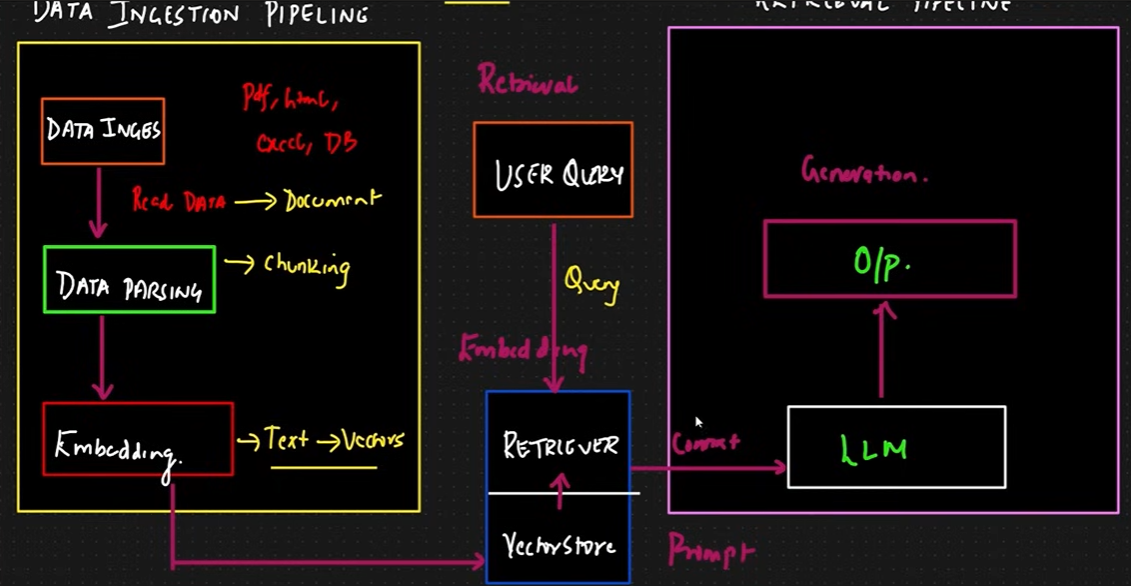

In [17]:
class RAGRetriever:
    """Handles query-based retrieval from the vector store"""
    
    def __init__(self, vector_store: VectorStore, embedding_manager: EmbeddingManager):
        """
        Initialize the retriever
        
        Args:
            vector_store: Vector store containing document embeddings
            embedding_manager: Manager for generating query embeddings
        """
        self.vector_store = vector_store
        self.embedding_manager = embedding_manager

    def retrieve(self, query: str, top_k: int = 5, score_threshold: float = 0.5) -> List[Dict[str, Any]]:
        """
        Retrieve relevant documents for a query
        
        Args:
            query: The search query
            top_k: Number of top results to return
            score_threshold: Minimum similarity score threshold
            
        Returns:
            List of dictionaries containing retrieved documents and metadata
        """
        print(f"Retrieving documents for query: '{query}'")
        print(f"Top K: {top_k}, Score threshold: {score_threshold}")
        
        # Generate query embedding
        #query_embedding = self.embedding_manager.generate_embeddings([query])[0]
        query_embedding = self.embedding_manager.generate_embeddings([query])[0]
        
        # Search in vector store
        try:
            results = self.vector_store.collection.query(
                query_embeddings=[query_embedding.tolist()],
                n_results=top_k
            )
            
            # Process results
            retrieved_docs = []
            
            if results['documents'] and results['documents'][0]:
                documents = results['documents'][0]
                metadatas = results['metadatas'][0]
                distances = results['distances'][0]
                ids = results['ids'][0]
                
                for i, (doc_id, document, metadata, distance) in enumerate(zip(ids, documents, metadatas, distances)):
                    # Convert distance to similarity score (ChromaDB uses cosine distance)
                    similarity_score = 1 - distance
                    
                    if similarity_score <= score_threshold:
                        retrieved_docs.append({
                            'id': doc_id,
                            'content': document,
                            'metadata': metadata,
                            'similarity_score': similarity_score,
                            'distance': distance,
                            'rank': i + 1
                        })
                
                print(f"Retrieved {len(retrieved_docs)} documents (after filtering)")
            else:
                print("No documents found")
            
            return retrieved_docs
            
        except Exception as e:
            print(f"Error during retrieval: {e}")
            return []

rag_retriever=RAGRetriever(vectorstore,embedding_manager)



In [18]:
rag_retriever

In [19]:
rag_retriever.retrieve("What are Social Networks based misinformation?")

Retrieving documents for query: 'What are Social Networks based misinformation?'
Top K: 5, Score threshold: 0.5
Generating embeddings for 1 texts...


Batches: 100%|██████████| 1/1 [00:00<00:00, 68.70it/s]

Generated embeddings with shape: (1, 384)
Retrieved 5 documents (after filtering)


[{'id': 'doc_3c042ada_60',
  'content': 'Simulating Misinformation Propagation in Social Networks using Large Language Models\nand the remaining 5 were in the ‘lie’ tier. This domain is followed\nbymarketing0,education0,technology0, andsports0among the top 5\npropagators. Here the majority of agent branches give MPR over 3:\nat least 7 agents crossing the ‘propaganda’ tier and the rest (i.e. 14 or\nless) in the ‘lie’ tier–except fortechnology0where they are equally\ndistributed across the 3 tiers (i.e. 7, 7, 7 in error, lie, propaganda).\nThese rankings highlight how disturbing or alarming news such\nas about crime and/or emotionally-charged and competitive con-\ntexts like sports enable rapid amplification.Marketing0exhibited\nhigh escalation likely because of the persuasive, attention-driven\nnature of marketing narratives. Education and technology (such as\nthe ethics of artificial intelligence) are also hot topics of discussion,\nand hence apparently more affected by misinformation

In [20]:
rag_retriever.retrieve("What is closed loop shaping")


Retrieving documents for query: 'What is closed loop shaping'
Top K: 5, Score threshold: 0.5
Generating embeddings for 1 texts...


Batches: 100%|██████████| 1/1 [00:00<00:00, 76.00it/s]

Generated embeddings with shape: (1, 384)
Retrieved 5 documents (after filtering)


[{'id': 'doc_0fc65acd_8',
  'content': 'larger control action in lower frequencies provides better disturbance \nrejection but injects higher noise into the observation band. Con-\nversely, lowering the control action reduces injected noise but results \nin insufficient disturbance rejection and possible loss of stability. \nLinear control systems theory shows fundamental limits to this \ntrade- off (10,\xa011) under certain assumptions about the controller de -\nsign. The ultimate aim of controller design is to shape the “closed- loop” \nbehavior, i.e., the performance of the designed controller acting in a \nfeedback loop with the plant.\nThere are many classical methods to achieve the desired closed-  \nloop behavior. Early methods, i.e., the classic (open)–loop shaping \nmethods, exploit the direct relationship between the open-  and \nclosed- loop transfer functions to design the controller. Since the \n1980s, the focus of design has shifted from open- loop design to di-',
  'meta

### RAG Pipeline- VectorDB To LLM Output Generation

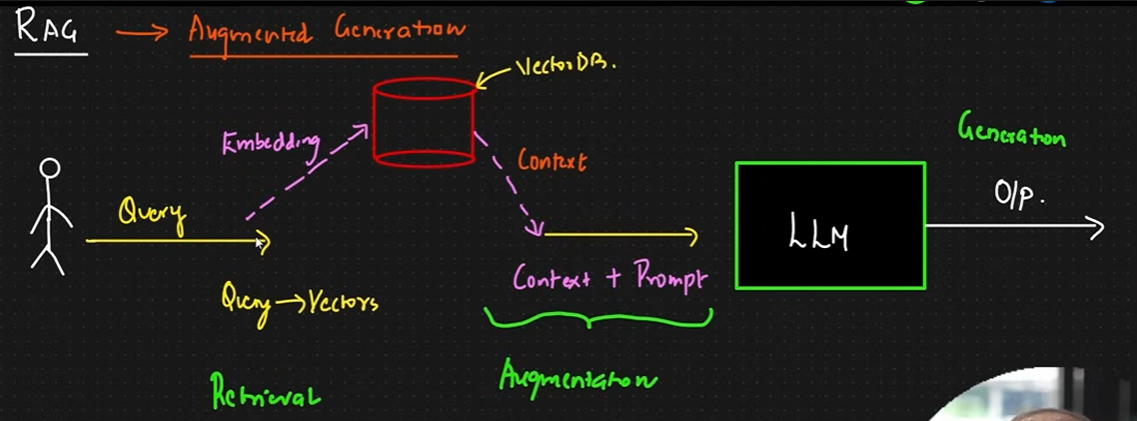

In [37]:
import os
from dotenv import load_dotenv
load_dotenv()

#print(os.getenv("GROQ_API_KEY"))

False

In [38]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain.messages import HumanMessage, SystemMessage

In [40]:
os.environ['OPENAI_API_KEY'] = 'REDACTED_API_KEY_r7FsNx1lfPpOPd7zUyuxoUyN_IbNAutb2SGzkmcZq7xxWs0EE2tEy5TxLaEoQ5VjyXnMCHJUA'

In [20]:
prompt_template = PromptTemplate(
            input_variables=["context", "question"],
            template="""You are a helpful AI assistant. Use the following context to answer the question accurately and concisely.

Context:
{context}

Question: {question}

Answer: Provide a clear and informative answer based on the context above. If the context doesn't contain enough information to answer the question, say so."""
        )

NameError: name 'PromptTemplate' is not defined

In [ ]:
class OpenAILLM:
    def __init__(self, model_name: str = "gemma2-9b-it", api_key: str =None):
        """
        Initialize OpenAI LLM
        
        Args:
            model_name: OpenAI model name (gemma2-9b-it, etc.)
            api_key: OpenAI API key (or set OPENAI_API_KEY environment variable)
        """
        self.model_name = model_name
        self.api_key = api_key or os.environ.get("OPENAI_API_KEY")
        
        if not self.api_key:
            raise ValueError("OpenAI API key is required. Set OPENAI_API_KEY environment variable or pass api_key parameter.")
        
        self.llm = ChatOpenAI(
            openai_api_key=self.api_key,
            model_name=self.model_name,
            temperature=0.1,
            max_tokens=1024
        )
        
        print(f"Initialized Groq LLM with model: {self.model_name}")

    def generate_response(self, query: str, context: str, max_length: int = 500) -> str:
        """
        Generate response using retrieved context
        
        Args:
            query: User question
            context: Retrieved document context
            max_length: Maximum response length
            
        Returns:
            Generated response string
        """
        
        # Create prompt template
        prompt_template = PromptTemplate(
            input_variables=["context", "question"],
            template="""You are a helpful AI assistant. Use the following context to answer the question accurately and concisely.

Context:
{context}

Question: {question}

Answer: Provide a clear and informative answer based on the context above. If the context doesn't contain enough information to answer the question, say so."""
        )
        
        # Format the prompt
        formatted_prompt = prompt_template.format(context=context, question=query)
        
        try:
            # Generate response
            messages = [HumanMessage(content=formatted_prompt)]
            response = self.llm.invoke(messages)
            return response.content
            
        except Exception as e:
            return f"Error generating response: {str(e)}"
        
    def generate_response_simple(self, query: str, context: str) -> str:
        """
        Simple response generation without complex prompting
        
        Args:
            query: User question
            context: Retrieved context
            
        Returns:
            Generated response
        """
        simple_prompt = f"""Based on this context: {context}

Question: {query}

Answer:"""
        
        try:
            messages = [HumanMessage(content=simple_prompt)]
            response = self.llm.invoke(messages)
            return response.content
        except Exception as e:
            return f"Error: {str(e)}"
    


In [ ]:
# Initialize Groq LLM (you'll need to set GROQ_API_KEY environment variable)
try:
    openai_llm = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
    print("OpenAI LLM initialized successfully!")
except ValueError as e:
    print(f"Warning: {e}")
    print("Please set your OPENAI_API_KEY environment variable to use the LLM.")
    openai_llm = None

Initialized Groq LLM with model: gemma2-9b-it
Groq LLM initialized successfully!


In [ ]:
### get the context from the retriever and pass it to the LLM

rag_retriever.retrieve("Unified Multi-task Learning Framework")

Retrieving documents for query: 'Unified Multi-task Learning Framework'
Top K: 5, Score threshold: 0.0
Generating embeddings for 1 texts...


Batches: 100%|██████████| 1/1 [00:00<00:00, 88.98it/s]

Generated embeddings with shape: (1, 384)
Retrieved 5 documents (after filtering)


[{'id': 'doc_bd5cc745_61',
  'content': 'erage scores on CMTEB[ 22] and MTEB[ 23] benchmarks, ranking ﬁrst overall on both\nCMTEB and MTEB leaderboards, demonstrating the eﬀectiveness o f our approach.\nThe contributions of our work are summarized as follows:\n• We propose a uniﬁed multi-task learning framework that systematic ally coordi-\nnates both data processing and training pipelines, enhancing divers ity in datasets\nand eﬃciency in model training ;\n• We develop advanced data synthesis techniques powered by LLM, in cluding Para-\nphrasing, Data augmentation, and Hard negative generation. The se methods\nsigniﬁcantly enhance the quality of training corpora, thereby impro ving model’s\nrobustness and generalization capabilities;\n• We emply a two-stage training paradigm: Stage 1 focuses exclusively on retrieval\ncapability building, establishing strong foundational retrieval perf ormance; and\nstage 2 implements balanced training with controled retrieval/non-r etrieval task',
  '

### Integration Vectordb Context pipeline With LLM output

In [21]:
### Simple RAG pipeline with Groq LLM
from langchain_openai import ChatOpenAI
import os
from dotenv import load_dotenv
load_dotenv()

os.environ['OPENAI_API_KEY'] = 'REDACTED_API_KEY_r7FsNx1lfPpOPd7zUyuxoUyN_IbNAutb2SGzkmcZq7xxWs0EE2tEy5TxLaEoQ5VjyXnMCHJUA'

### Initialize the Groq LLM (set your GROQ_API_KEY in environment)
openai_api_key = os.environ['OPENAI_API_KEY']
llm=ChatOpenAI(api_key=openai_api_key,model_name="gpt-4o-mini",temperature=0.1,max_tokens=1024)

## 2. Simple RAG function: retrieve context + generate response
def rag_simple(query,retriever,llm,top_k=3):
    ## retriever the context
    results=retriever.retrieve(query,top_k=top_k)
    context="\n\n".join([doc['content'] for doc in results]) if results else ""
    if not context:
        return "No relevant context found to answer the question."
    
    ## generate the answwer using OPENAI LLM
    prompt=f"""Use the following context to answer the question concisely.
        Context:
        {context}

        Question: {query}

        Answer:"""
    
    response=llm.invoke([prompt.format(context=context,query=query)])
    return response.content

In [22]:
answer=rag_simple("What are Social Networks based misinformation?",rag_retriever,llm)
answer

Retrieving documents for query: 'What are Social Networks based misinformation?'
Top K: 3, Score threshold: 0.5
Generating embeddings for 1 texts...


Batches: 100%|██████████| 1/1 [00:00<00:00, 38.99it/s]

Generated embeddings with shape: (1, 384)
Retrieved 3 documents (after filtering)


'Social networks-based misinformation refers to false or misleading information that spreads rapidly through social media platforms and online communities. This type of misinformation can take various forms, including rumors, hoaxes, and propaganda, often amplified by user engagement and emotional content. It is particularly prevalent in domains such as crime, sports, marketing, education, and technology, where alarming or emotionally charged narratives can lead to high levels of propagation and escalation among users.'

### Enhanced RAG Pipeline Features

In [ ]:
# --- Enhanced RAG Pipeline Features ---
def rag_advanced(query, retriever, llm, top_k=5, max_score=0.2, return_context=False):
    """
    RAG pipeline with extra features:
    - Returns answer, sources, confidence score, and optionally full context.
    """
    results = retriever.retrieve(query, top_k=top_k, score_threshold=max_score)
    if not results:
        return {'answer': 'No relevant context found.', 'sources': [], 'confidence': 0.0, 'context': ''}
    
    # Prepare context and sources
    context = "\n\n".join([doc['content'] for doc in results])
    sources = [{
        'source': doc['metadata'].get('source_file', doc['metadata'].get('source', 'unknown')),
        'page': doc['metadata'].get('page', 'unknown'),
        'score': doc['similarity_score'],
        'preview': doc['content'][:300] + '...'
    } for doc in results]
    confidence = min([doc['similarity_score'] for doc in results])
    
    # Generate answer
    prompt = f"""Use the following context to answer the question concisely.\nContext:\n{context}\n\nQuestion: {query}\n\nAnswer:"""
    response = llm.invoke([prompt.format(context=context, query=query)])
    
    output = {
        'answer': response.content,
        'sources': sources,
        'confidence': confidence
    }
    if return_context:
        output['context'] = context
    return output

# Example usage:
result = rag_advanced("What are Social Networks based misinformation?", rag_retriever, llm, top_k=3, max_score=0.3, return_context=True)
print("Answer:", result['answer'])
print("Sources:", result['sources'])
print("Confidence:", result['confidence'])
print("Context Preview:", result['context'][:300])
#result

Retrieving documents for query: 'What are Social Networks based misinformation?'
Top K: 3, Score threshold: 0.3
Generating embeddings for 1 texts...


Batches: 100%|██████████| 1/1 [00:00<00:00, 39.97it/s]

Generated embeddings with shape: (1, 384)
Retrieved 3 documents (after filtering)


Answer: Social networks-based misinformation refers to false or misleading information that spreads rapidly through social media platforms and online communities. This type of misinformation can take various forms, including rumors, hoaxes, and propaganda, often amplified by emotionally charged content or persuasive narratives. It can significantly impact public perception and behavior, particularly in sensitive areas such as crime, marketing, education, and technology.
Sources: [{'source': 'SN_misinformation.pdf', 'page': 4, 'score': 0.20115363597869873, 'preview': 'Simulating Misinformation Propagation in Social Networks using Large Language Models\nand the remaining 5 were in the ‘lie’ tier. This domain is followed\nbymarketing0,education0,technology0, andsports0among the top 5\npropagators. Here the majority of agent branches give MPR over 3:\nat least 7 agents ...'}, {'source': 'SN_misinformation.pdf', 'page': 4, 'score': 0.20115363597869873, 'preview': 'Simulating Misinformation 

: 

In [ ]:
# --- Advanced RAG Pipeline: Streaming, Citations, History, Summarization ---
from typing import List, Dict, Any
import time

class AdvancedRAGPipeline:
    def __init__(self, retriever, llm):
        self.retriever = retriever
        self.llm = llm
        self.history = []  # Store query history

    def query(self, question: str, top_k: int = 5, max_score: float = 0.2, stream: bool = False, summarize: bool = False) -> Dict[str, Any]:
        # Retrieve relevant documents
        results = self.retriever.retrieve(question, top_k=top_k, score_threshold=max_score)
        if not results:
            answer = "No relevant context found."
            sources = []
            context = ""
        else:
            context = "\n\n".join([doc['content'] for doc in results])
            sources = [{
                'source': doc['metadata'].get('source_file', doc['metadata'].get('source', 'unknown')),
                'page': doc['metadata'].get('page', 'unknown'),
                'score': doc['similarity_score'],
                'preview': doc['content'][:120] + '...'
            } for doc in results]
            # Streaming answer simulation
            prompt = f"""Use the following context to answer the question concisely.\nContext:\n{context}\n\nQuestion: {question}\n\nAnswer:"""
            if stream:
                print("Streaming answer:")
                for i in range(0, len(prompt), 80):
                    print(prompt[i:i+80], end='', flush=True)
                    time.sleep(0.05)
                print()
            response = self.llm.invoke([prompt.format(context=context, question=question)])
            answer = response.content

        # Add citations to answer
        citations = [f"[{i+1}] {src['source']} (page {src['page']})" for i, src in enumerate(sources)]
        answer_with_citations = answer + "\n\nCitations:\n" + "\n".join(citations) if citations else answer

        # Optionally summarize answer
        summary = None
        if summarize and answer:
            summary_prompt = f"Summarize the following answer in 2 sentences:\n{answer}"
            summary_resp = self.llm.invoke([summary_prompt])
            summary = summary_resp.content

        # Store query history
        self.history.append({
            'question': question,
            'answer': answer,
            'sources': sources,
            'summary': summary
        })

        return {
            'question': question,
            'answer': answer_with_citations,
            'sources': sources,
            'summary': summary,
            'history': self.history
        }

# Example usage:
adv_rag = AdvancedRAGPipeline(rag_retriever, llm)
result = adv_rag.query("what is attention is all you need", top_k=3, min_score=0.1, stream=True, summarize=True)
print("\nFinal Answer:", result['answer'])
print("Summary:", result['summary'])
print("History:", result['history'][-1])

Retrieving documents for query: 'what is attention is all you need'
Top K: 3, Score threshold: 0.1
Generating embeddings for 1 texts...


Batches: 100%|██████████| 1/1 [00:00<00:00, 88.93it/s]

Generated embeddings with shape: (1, 384)
Retrieved 3 documents (after filtering)
Streaming answer:
Use the following context to answer the question concisely.
Context:
3.2 Attention
An attention function can be described as mapping a query and a set of key-value pairs to an output,
where the query, keys, values, and output are all vectors. The output is computed as a weighted sum
3

3.2 Attention
An attention functi

on can be described as mapping a query and a set of key-value pairs to an output,
where the query, keys, values, and output are all vectors. The output is computed as a weighted sum
3

3.2 Attention
An attention function can be described as mapping a query and a set of key-value pairs to an output,
where the query, keys, values, and output are all vectors. The output is computed as a weighted sum
3

Question: what is attention is all you need

Answer:

Final Answer: "Attention Is All You Need" is a paper that introduced the Transformer model, which relies solely on attention mechanisms for sequence transduction tasks, eliminating the need for recurrent or convolutional networks.  


Citations:
[1] attention.pdf (page 2)
[2] attention.pdf (page 2)
[3] attention.pdf (page 2)
Summary: The paper "Attention Is All You Need" introduced the Transformer model, a novel architecture for sequence transduction tasks.  This model utilizes only attention mechanisms, dispensing with traditional recur